# Ejemplo real: detección de uvas en viñedos

El siguiente problema es un problema real en el que estamos trabajando al momento de dictar este curso.
Los datos fueron extraídos de un viñedo en Uruguay y procesados por nosotros.

El ejercicio que vamos a hacer es intentar identificar qué de una imagen pixeles pertenecen a una uva, y qué pixeles no.
Para esto nos vamos a apoyar en anotaciones hechas por nuestros algoritmos. Intentaremos replicar estos resultados utilizando una estrategia muy sencilla: mirar el color de las uvas. 

Esto no va a funcionar tan bien como lo otro, pero va a mostrar el tipo de cosas que se pueden hacer.


## Datos

Las imágenes son fotos de uvas en viñedos. Cada imagen está acompañada de una máscara que indica si un pixel es "uva" o no.

### Descarga

In [1]:
from urllib import request
from zipfile import ZipFile
import os
import glob

remote_url="https://iie.fing.edu.uy/dps/datos/publico/vino/vino_fino/masks/2024-03-04-vino_fino_sector_0-1.zip"
local_file="vino_fino_train.zip"
request.urlretrieve(remote_url, local_file)
with ZipFile(local_file, 'r') as zf:
    zf.extractall("train")

remote_url="https://iie.fing.edu.uy/dps/datos/publico/vino/vino_fino/masks/2024-03-04-vino_fino_sector_122_123.zip"
local_file="vino_fino_test.zip"
request.urlretrieve(remote_url, local_file)
with ZipFile(local_file, 'r') as zf:
    zf.extractall("test")



## Carga en memoria

In [2]:
import skimage.io as imgio
#
# armamos listas de imágenes y sus máscaras
#
train_image_list = glob.glob("train/2024-03-04-vino_fino_sector_0-1/images/*.png")
train_mask_list = sorted([i for i in train_image_list if "mask" in i])
train_image_list = sorted([i for i in train_image_list if "mask" not in i])
ntrain = len(train_image_list)
assert(len(train_mask_list) == ntrain)
print('Imagenes de entrenamiento:',ntrain)

test_image_list = glob.glob("test/2024-03-04-vino_fino_sector_122_123/images/*.png")
test_mask_list  = sorted([i for i in test_image_list if "mask" in i])
test_image_list = sorted([i for i in test_image_list if "mask" not in i])
ntest = len(test_image_list)
assert(len(test_mask_list) == ntest)
print('Imagenes de evaluacion:',ntest)

#
# cargamos las imágenes en memoria
train_images = [imgio.imread(i)/255 for i in train_image_list]
train_masks  = [imgio.imread(i)/255 for i in train_mask_list]

test_images = [imgio.imread(i)/255 for i in test_image_list]
test_masks  = [imgio.imread(i)/255 for i in test_mask_list]

#
# le recortamos un poco arriba y abajo para ahorrar
# cómputo y porque no hay nada ahí.
#
crop = train_images[0].shape[0]//5

train_images = [i[crop:-crop,:,:] for i in train_images]
train_masks  = [i[crop:-crop,:] for i in train_masks]

test_images = [i[crop:-crop,:,:] for i in test_images]
test_masks  = [i[crop:-crop,:] for i in test_masks]


Imagenes de entrenamiento: 5
Imagenes de evaluacion: 5


## Muestra de ejemplo

Veamos abajo algunas de las imágenes que cargamos.

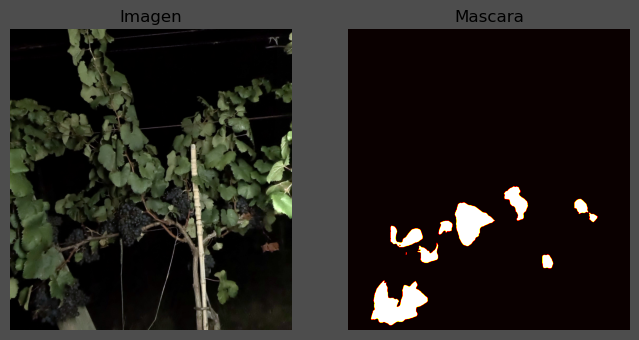

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

import numpy as np
import numpy.random as rng

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 150

mpl.rcParams['font.size'] = 10
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'


plt.figure(figsize=(8,8),facecolor=(0.3,0.3,0.3))
plt.subplot(1,2,1)
plt.imshow(train_images[0])
plt.title('Imagen')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_masks[0],cmap='hot')
plt.title('Mascara')
plt.axis('off')
plt.show()


# Clasificación en base a color

Lo que vamos a hacer ahora es construir un clasificador  que nos diga si un pixel dado es parte de una uva o no. 
La entrada al clasificador es el valor de un pixel, que consiste en tres componentes de color: rojo (R), erde (G) y azul (B): $x=(r,g,b) \in \mathbb{R}^3$.
Las imágenes de entrenamiento, con sus máscaras, ya nos proveen decenas de miles de pares de entrenamiento de tipo $(x,y)$ donde $x$ son los pixeles de la imagen e $y$ el valor correspondiente en la máscara, que vale $0$ o $1$.

Tenemos $5$ imágenes de entrenamiento (con sus máscaras) y $5$ imágenes de evaluación. Las últimas no las vamos  a tocar. 
El clasificador, una regresión logística, va a ser entrenado por validación cruzada utilizando $4$ imágenes para ajustar el modelo y $1$ para evaluar. Esto lo podemos hacer de $5$ maneras distintas y con el desempeño promedio podemos calibrar el hiperparámetro del algoritmo ($C$).


### Análisis exploratorio

Una de las las buenas prácticas más importantes en la aplicación del aprendizaje automático es realizar siempre un análisis exploratorio en el cual uno pueda obserar los datos. No siempre se puede, pero en este caso sí podemos hacerlo. Los datos que tenemos son tridimensionales, así que es difícil observarlos con sus tres variables a la vez. Lo que haremos es un `pairwise plot` en donde mostramos gráficas de las variables tomadas de a 2.

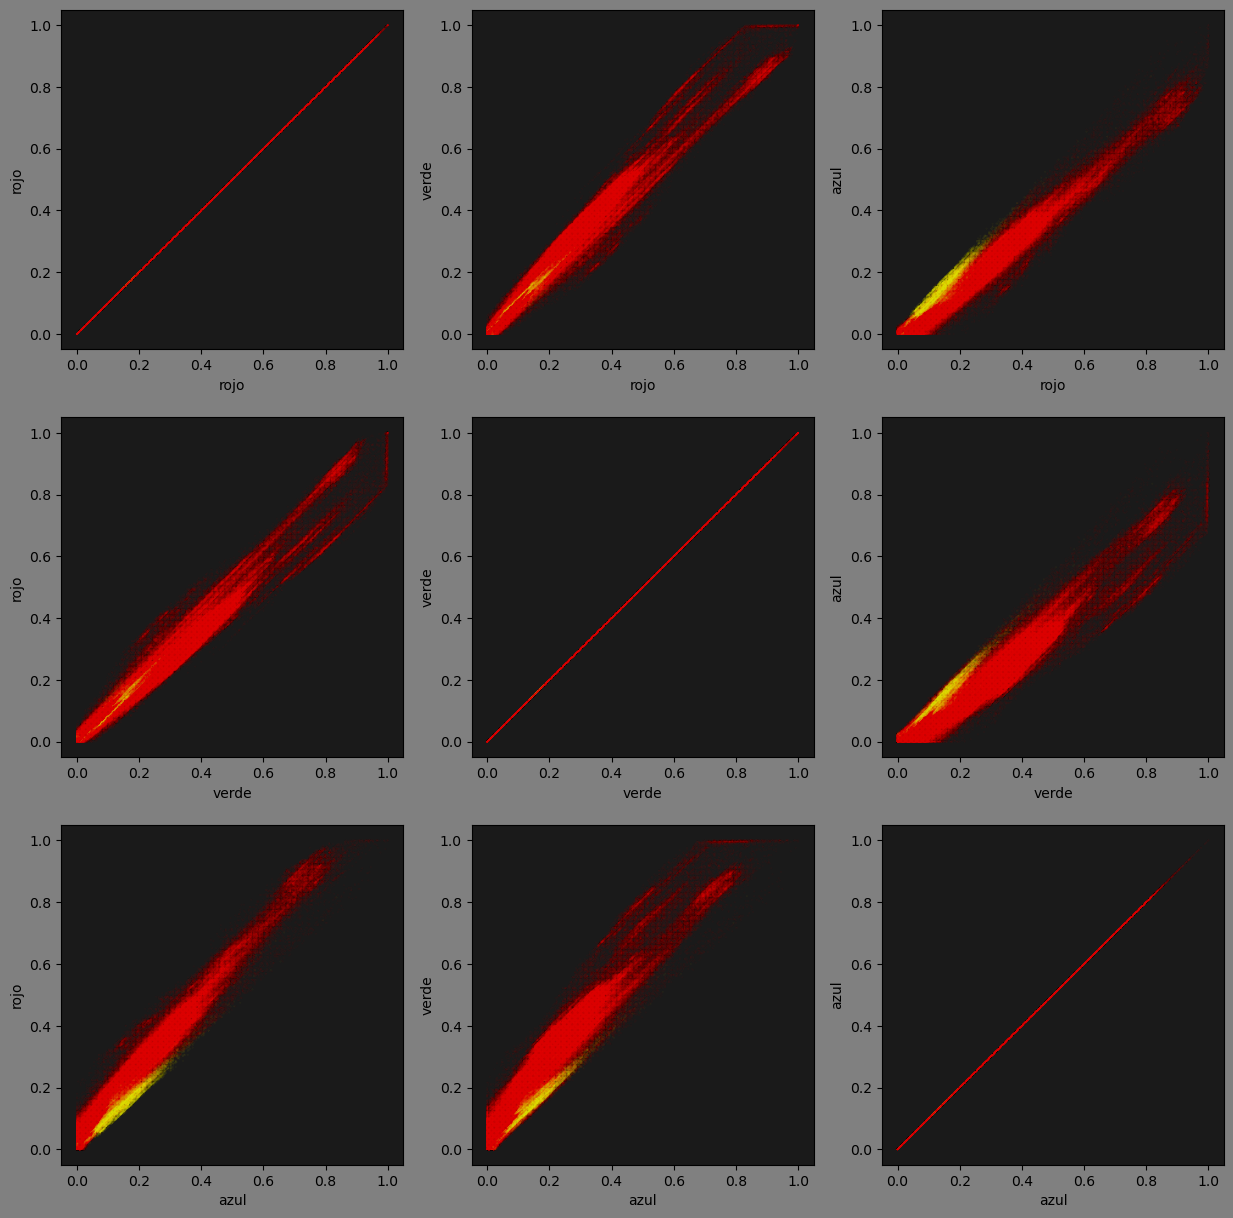

In [4]:
# un buen paquete para hacer esto de manera elegante es seaborn
# para mantener los requisitos al mínimo, realizaremos esta gráfica a mano
import numpy as np

def pair_plot(train_images,train_masks,labels=['rojo','verde','azul']):
    M,N,NC = train_images[0].shape
    plt.figure(figsize=(15,15),facecolor=(.5,.5,.5))
    # demasiados puntos!
    #X_train = np.concatenate([np.reshape(train_images[i],(M*N,NC)) for i in range(ntrain)],axis=0)
    #y_train = np.concatenate([np.reshape(train_masks[i],(-1)) for i in range(ntrain)])
    X_train = np.reshape(train_images[0],(M*N,NC))
    y_train = np.reshape(train_masks[0],(-1))
    for i in range(3):
        for j in range(3):
            plt.subplot(3,3,3*i+j+1,facecolor=(0.1,0.1,0.1))
            plt.scatter(X_train[:,i],X_train[:,j],c=y_train[:],s=0.1,cmap='autumn',alpha=0.05)
            plt.xlabel(labels[i])
            plt.ylabel(labels[j])
    plt.show()

pair_plot(train_images=train_images,train_masks=train_masks)


### Primera acercamiento: regresión logística (lineal)

El primer modelo que vamos a probar es una regresión logística como la que vimos en el práctico de clasificación.
La mayor limitante de este modelo es que es lineal, es decir, divide el espacio de decisiones por un hiperplano.
Si los datos (uva - no uva) no son fácilmente separables en ese espacio, entonces no vamos a poder hacer mucho.
Del análisis exploratorio anterior puede verse que hay cierto grado de separación entre las clases (rojo s. amarillo), pero no es total.
En todo caso, esto nos va a dar un primer enfoque sencillo para trabajar, y una cota inferior al desempeño.

### Cómo lidiar con el desbalance de clases

La cantidad de pixeles con uvas es bastante menor que la de pixels sin uvas.
Esto significa que obtendremos un buen _score_ de predicción simplemente diciendo que nunca hay uvas.
Pero eso no es lo que queremos!

Para corregir esto, sopesamos cada clase con un peso inversamente proporcional a su cantidad. Esto es algo que varía mucho.
Lo definimos a mano como $(1/5,4/5)$

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from skimage.color import rgb2hsv

def train_model(train_images,train_masks):
    models = list()
    scores = list()
    class_weights = {0:0.25,1:0.75}
    M,N,NC = train_images[0].shape
    Cvals = [1e-3,1e-2,1e-1,1e-0,1e1,1e2,1e3]
    for c,C in enumerate(Cvals):
        train_scores_c = list()
        test_scores_c = list()
        print(f'LogisticRegression C={C}:')
        for k in range(ntrain):
            X_val = np.reshape(train_images[k],(M*N,NC))
            X_train = np.concatenate([np.reshape(train_images[i],(M*N,NC)) for i in range(ntrain) if i != k],axis=0)
            y_val   = np.reshape(train_masks[k],(-1))
            y_train = np.concatenate([np.reshape(train_masks[i],(-1)) for i in range(ntrain) if i != k])

            model_c       = LogisticRegression(C=C,penalty='l2',max_iter=1000,class_weight=class_weights)
            model_c       = model_c.fit(X_train, y_train)
            if k == 0:
                models.append(model_c) # guardamos uno de los modelos para usarlo luego
            #
            # medimos la calidad del ajuste en entrenamiento y test
            #
            train_score_k = model_c.score(X_train, y_train)
            test_score_k  = model_c.score(X_val, y_val)
            train_scores_c.append(train_score_k)
            test_scores_c.append(test_score_k)
            print(f"\tfold {k} score train: {train_score_k:.4f} test: {test_score_k:.4f}")

        mean_train_score = np.mean(train_scores_c)
        mean_test_score = np.mean(test_scores_c)
        std_test_score = np.std(test_scores_c)
        std_train_score = np.std(train_scores_c)
        print(f'Final score {mean_test_score:.4f} +/- {std_test_score:.4f}')
        scores.append(mean_test_score-std_test_score) # peor caso
    #
    # elegimos el modelo con el mejor peor caso
    #
    k_best = np.argmax(scores)
    model_best = models[k_best]
    print(f'Mejor modelo: C={Cvals[k_best]}')
    return model_best

model = train_model(train_images,train_masks)

LogisticRegression C=0.001:
	fold 0 score train: 0.9206 test: 0.9543
	fold 1 score train: 0.9246 test: 0.9384
	fold 2 score train: 0.9296 test: 0.9183
	fold 3 score train: 0.9404 test: 0.8752
	fold 4 score train: 0.9216 test: 0.9505
Final score 0.9273 +/- 0.0289
LogisticRegression C=0.01:
	fold 0 score train: 0.9300 test: 0.9532
	fold 1 score train: 0.9316 test: 0.9339
	fold 2 score train: 0.9355 test: 0.9112
	fold 3 score train: 0.9366 test: 0.8879
	fold 4 score train: 0.9287 test: 0.9514
Final score 0.9275 +/- 0.0249
LogisticRegression C=0.1:
	fold 0 score train: 0.9435 test: 0.9563
	fold 1 score train: 0.9445 test: 0.9408
	fold 2 score train: 0.9475 test: 0.9244
	fold 3 score train: 0.9437 test: 0.9302
	fold 4 score train: 0.9411 test: 0.9594
Final score 0.9422 +/- 0.0138
LogisticRegression C=1.0:
	fold 0 score train: 0.9455 test: 0.9574
	fold 1 score train: 0.9467 test: 0.9424
	fold 2 score train: 0.9499 test: 0.9273
	fold 3 score train: 0.9462 test: 0.9365
	fold 4 score train: 0.9

## Evaluación en imágenes de test

Veamos ahora cómo se comparan las máscaras obtenidas con el regresor logístoco contra las máscaras existentes.



imagen 0 score 0.9140


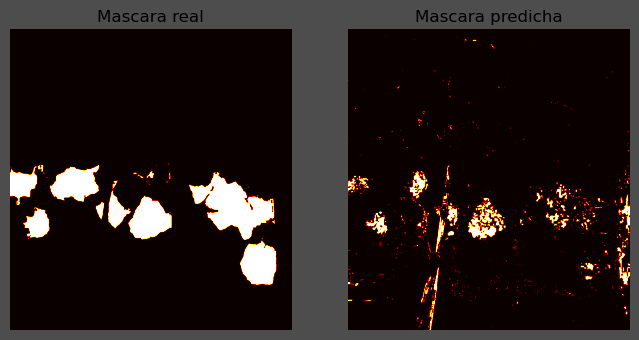

imagen 1 score 0.9697


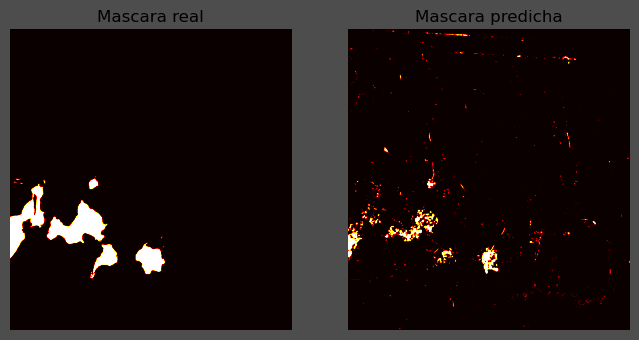

imagen 2 score 0.9874


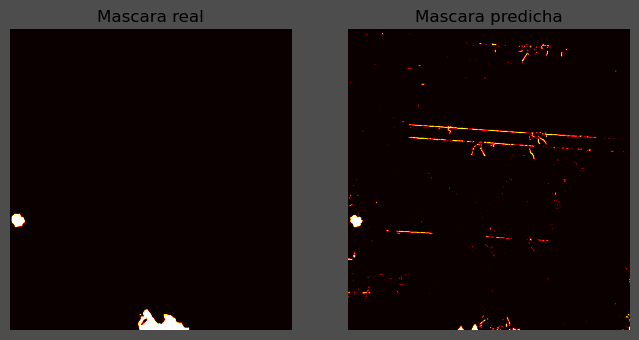

imagen 3 score 0.9447


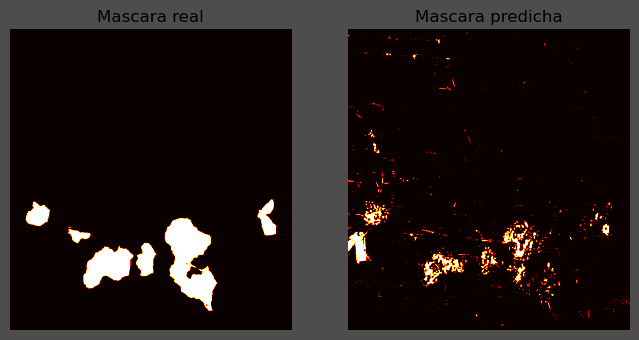

imagen 4 score 0.9511


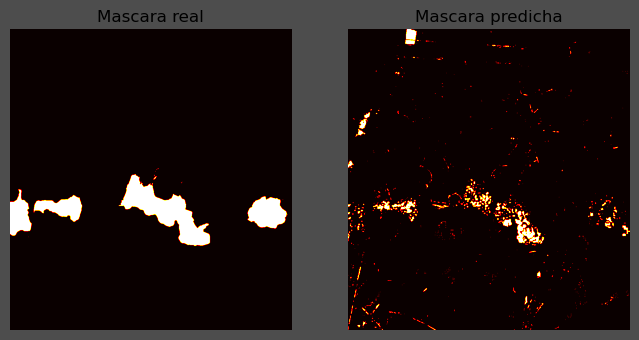

In [6]:
def eval_model(model,test_images,test_masks):
    for j,I in enumerate(test_images):
        M,N,C = I.shape
        X = np.reshape(I,(M*N,C))
        y_pred = model.predict(X)
        true_mask = test_masks[j]
        y = np.reshape(true_mask,(-1))
        score = model.score(X,y)
        print(f'imagen {j} score {score:.4f}')
        pred_mask = np.reshape(y_pred,true_mask.shape)
        plt.figure(figsize=(8,8),facecolor=(0.3,0.3,0.3))
        plt.subplot(1,2,1)
        plt.imshow(true_mask,cmap='hot')
        plt.title('Mascara real')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(pred_mask,cmap='hot')
        plt.title('Mascara predicha')
        plt.axis('off')
        plt.show()

eval_model(model,test_images,test_masks)

## Conclusiones

Dada la sencillez del enfoque (pretender detectar uvas sólamente en base al color!), el resultado es sorprendentemente bueno.
Las uvas son detectadas con buena precisión. Lo que ocurre son muchas detecciones falsas en zonas donde el color es similar.
Además, este clasificador no tiene noción espacial alguna, por lo que no hay coherencia espacial tampoco: cada pixel es clasificado de forma independiente del resto, cuando sabemos bien que los racimos son conjuntos de pixeles conexos. Todo esto puede utilizarse para mejorar este esquema.





# Segunda aproximación: vecinos más cercanos

Una forma sencilla de clasificar de manera no lineal es utilizar el método conocido como vecinos más cercanos. Este es un método _no paramétrico_, en el sentido de que el modelo que se obtiene no tiene parámetros. 



In [20]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
X = np.reshape(train_images[0],(M*N,NC))
y = np.reshape(train_masks[0],(-1))
model.fit(X,y)
y_pred = model.predict(np.reshape(test_images[0],(M*N,NC)))
y_test = np.reshape(test_masks[0],(-1))

0.9238578639403292
imagen 0 score 0.9239


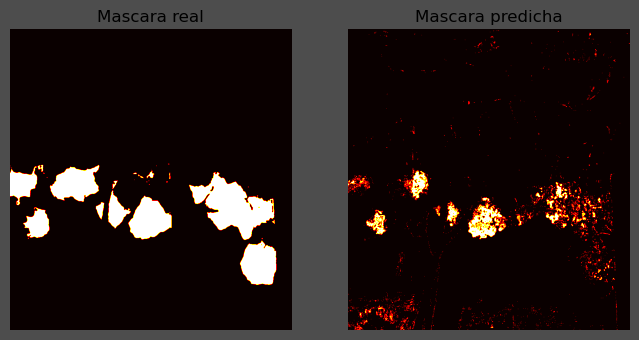

imagen 1 score 0.9721


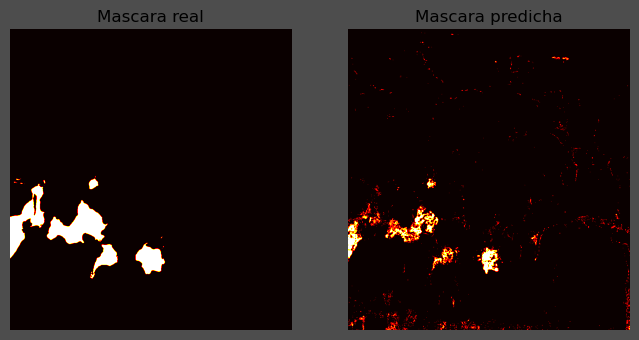

imagen 2 score 0.9894


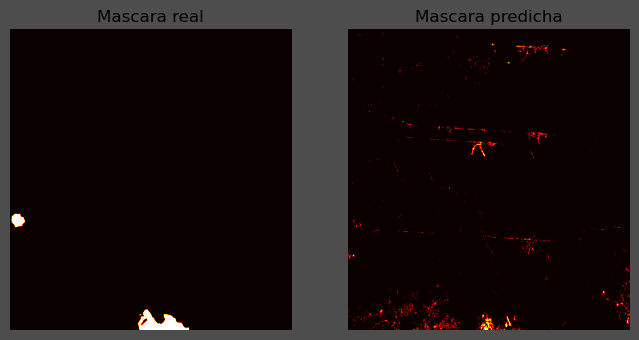

imagen 3 score 0.9540


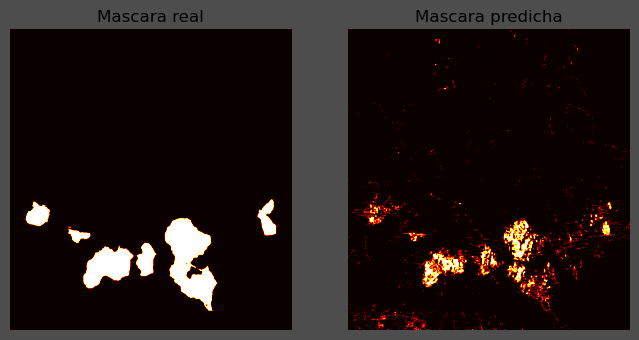

imagen 4 score 0.9573


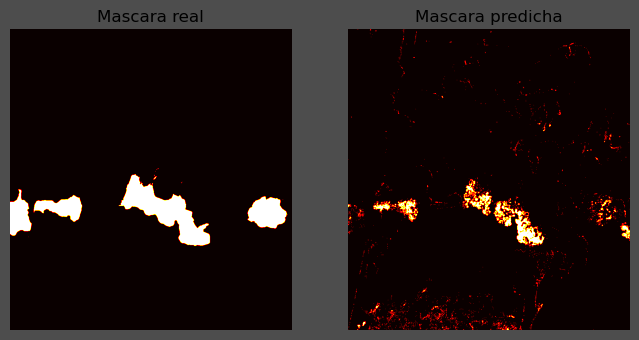

In [21]:
from sklearn import metrics
score = metrics.accuracy_score(y_test,y_pred)
print(score)
eval_model(model,test_images,test_masks)

# Tercer modelo: red neuronal 

Ahora vamos a dar dos pasos grandes:
* Más contexto: para determinar si un pixel es uva o no uva, vamos a usar _varios_ pixeles: él, y sus vecinos.
* Lo anterior implica que nuestro modelo pasa de tener una entrada de $3$ valores (rojo, verde, azul) a una entrada de $3{\times}n$ valores, en donde $n$ es la cantidad de vecinos que vamos a usar.
* Como vamos a usar información espacial, nos conviene utilizar un método que tome en cuenta la espacialidad.
* Lo que vamos a usar es una _red neuronal convolucional_. 
* Para esta parte es necesario contar con una GPU y la biblioteca _Pytorch_ funcionando en el entorno de Python.